In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Fix the path construction - use forward slashes or raw strings
import os

# Method 1: Use forward slashes (recommended)
path = os.path.abspath(os.path.join("..", "01_CDL_Patterns_Strategy", "data", "USA500IDXUSD_H1_raw.csv"))

# Alternative Method 2: Use raw string
# path = os.path.abspath(os.path.join("..", r"04_S&P500_quant_analysis\01_data", "S&P500_D_1789-05-01_2025-09-17.csv"))

# Alternative Method 3: Use pathlib (modern approach)
# from pathlib import Path
# path = Path("..") / "04_S&P500_quant_analysis" / "01_data" / "S&P500_D_1789-05-01_2025-09-17.csv"

# print(f"Path exists: {os.path.exists(path)}")

# Read the CSV file
df = pd.read_csv(path)

# lower case column names for easier access
df.columns = [col.lower() for col in df.columns]

# convert date column to string
df['date'] = df['date'].astype(str)

# split date column into YYYY-MM-DD format
df['year'] = df['date'].str.slice(0, 4).astype(int)
df['month'] = df['date'].str.slice(4, 6).astype(int)
df['day'] = df['date'].str.slice(6, 8).astype(int)

# drop date column
df.drop(columns=['date'], inplace=True)

# add date column in YYYY-MM-DD format
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# Set the 'date' column as the index and convert it to datetime
df.set_index('date', inplace=True)

# Handle timestamp processing - check the format first
timestamp_sample = df['timestamp'].iloc[0]

# Handle different timestamp formats
if ':' in str(timestamp_sample):
    # If timestamp is already in HH:MM format
    df['timestamp'] = df['timestamp'].astype(str)
    # Split by colon
    time_parts = df['timestamp'].str.split(':', expand=True)
    df['hour'] = time_parts[0].astype(int)
    df['minute'] = time_parts[1].astype(int)
else:
    # If timestamp is in HHMM format (no colon)
    df['timestamp'] = df['timestamp'].astype(str)
    # Ensure timestamp is zero-padded to 4 digits
    df['timestamp'] = df['timestamp'].str.zfill(4)
    df['hour'] = df['timestamp'].str.slice(0, 2).astype(int)
    df['minute'] = df['timestamp'].str.slice(2, 4).astype(int)

# drop timestamp, year, month, day columns
df.drop(columns=['timestamp', 'year', 'month', 'day'], inplace=True)

# add time column in HH:MM:SS format
df['timestamp'] = pd.to_datetime(df[['hour', 'minute']]
                        .assign(second=0)
                        .astype(str)
                        .agg(':'.join, axis=1),
                        format='%H:%M:%S').dt.time

# drop hour	minute columns
df.drop(columns=['hour', 'minute'], inplace=True)

# reorder columns to have timestamp as the first column
cols = df.columns.tolist()
cols = ['timestamp'] + [col for col in cols if col != 'timestamp']
df = df[cols]

# Show the first few rows of the dataframe
df.head()

,timestamp,open,high,low,close,volume
date,,,,,,
2019-09-30,02:00:00,2969.670,2971.17,2968.170,2969.67,1.64595
2019-09-30,03:00:00,2969.870,2975.67,2969.670,2973.67,2.23279
2019-09-30,04:00:00,2973.869,2977.17,2973.170,2975.37,0.99898
2019-09-30,05:00:00,2975.670,2976.17,2974.369,2975.67,0.69730
2019-09-30,06:00:00,2975.670,2975.67,2971.770,2972.17,0.68437


In [16]:
"""
The 1-hour data strategy will be applied to the last quarter of 2025, i.e., from 2025-10-01 to 2025-12-31.
As we want to generate synthetic data for this period, we will use historical hourly returns from:
1) 2019-10-01 to 2019-12-31
2) 2020-10-01 to 2020-12-31
3) 2021-10-01 to 2021-12-31
4) 2022-10-01 to 2022-12-31
5) 2023-10-01 to 2023-12-31
6) 2024-10-01 to 2024-12-31

As a first step, we will extract hourly returns from these periods.
We will then combine these returns to create a larger sample for bootstrapping.
""";

In [17]:
# from DatetimeIndex, filter data for the last quarter of each year from 2019 to 2024
df_2019_q4 = df['2019-10-01':'2019-12-31']
df_2020_q4 = df['2020-10-01':'2020-12-31']
df_2021_q4 = df['2021-10-01':'2021-12-31']
df_2022_q4 = df['2022-10-01':'2022-12-31']
df_2023_q4 = df['2023-10-01':'2023-12-31']
df_2024_q4 = df['2024-10-01':'2024-12-31']

# list of dataframes
dfs = [df_2019_q4, df_2020_q4, df_2021_q4, df_2022_q4, df_2023_q4, df_2024_q4]

# drop columns timestamp, open, high, low, close, volume for each dataframe
for i in dfs:
    i = i.drop(columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# Calculate simple returns with pct_change() for each dataframe
for i in dfs:
    i['simple_returns'] = i['close'].pct_change()

# rename simple_returns column to returns for each dataframe
for i in dfs:
    i.rename(columns={'simple_returns': 'returns'}, inplace=True)
    
# drop NaN values for each dataframe
for i in dfs:
    i = i.dropna()

# concatenate all dataframes in the list
df = pd.concat(dfs)

daily_returns = df.copy()

In [18]:
# check unique months and years in the concatenated dataframe
print(df.index.to_period('M').unique())
print(df.index.to_period('Y').unique())

PeriodIndex(['2019-10', '2019-11', '2019-12', '2020-10', '2020-11', '2020-12',
             '2021-10', '2021-11', '2021-12', '2022-10', '2022-11', '2022-12',
             '2023-10', '2023-11', '2023-12', '2024-10', '2024-11', '2024-12'],
            dtype='period[M]', name='date')
PeriodIndex(['2019', '2020', '2021', '2022', '2023', '2024'], dtype='period[Y-DEC]', name='date')


In [19]:
daily_returns.head()

,timestamp,open,high,low,close,volume,returns
date,,,,,,,
2019-10-01,00:00:00,2982.570,2985.369,2981.369,2981.569,0.246868,NaN
2019-10-01,01:00:00,2981.869,2983.870,2981.069,2981.569,0.437762,0.000000
2019-10-01,02:00:00,2981.870,2986.570,2980.570,2986.070,1.300740,0.001510
2019-10-01,03:00:00,2986.370,2990.570,2986.070,2988.070,1.667874,0.000670
2019-10-01,04:00:00,2988.369,2988.870,2987.370,2987.570,0.667876,-0.000167


In [20]:
hist_returns = daily_returns['returns'].values  # numpy array of decimal returns
hist_returns

array([        nan,  0.        ,  0.00150961, ...,  0.00165929,
       -0.00034772,  0.00042855], shape=(8869,))

In [ ]:
# Monte Carlo Synthetic Returns Generator for S&P 500
# Three advanced methodologies for generating realistic synthetic return series
from tqdm import tqdm

# Parametric Monte Carlo - Gaussian (simple)
def parametric_normal_simulation(mu: float,
                                sigma: float,
                                n_steps: int,
                                n_paths: int,
                                seed: int = None) -> np.ndarray:
    """
    Generate synthetic returns using Normal(mu, sigma).
    Output shape: (n_steps, n_paths)
    """
    rng = np.random.RandomState(seed)
    # draw returns independently for each step/path
    sims = rng.normal(loc=mu, scale=sigma, size=(n_steps, n_paths))
    return sims

# Non-parametric bootstrap (IID resampling of historical returns)
def bootstrap_simulation(hist_returns: np.ndarray,
                         n_steps: int,
                         n_paths: int,
                         seed: int = None) -> np.ndarray:
    """
    Generate synthetic returns by resampling historical returns with replacement.
    hist_returns: 1D array of historical returns (decimal)
    """
    rng = np.random.RandomState(seed)
    idx = rng.randint(0, len(hist_returns), size=(n_steps, n_paths))
    sims = hist_returns[idx]
    return sims

# Moving block bootstrap - preserves short-range dependence
def block_bootstrap_simulation(hist_returns: np.ndarray,
                               n_steps: int,
                               n_paths: int,
                               block_size: int = 5,
                               seed: int = None) -> np.ndarray:
    """
    Generate synthetic returns via moving block bootstrap.
    The procedure:
      - Partition the historical returns into overlapping blocks of length block_size
      - For each path, sample blocks with replacement until we reach n_steps
      - Trim the last block if it exceeds n_steps
    This preserves intra-block autocorrelation.
    """
    rng = np.random.RandomState(seed)
    T = len(hist_returns)
    # create overlapping blocks
    blocks = [hist_returns[i:i+block_size] for i in range(0, T - block_size + 1)]
    n_blocks = len(blocks)
    sims = np.zeros((n_steps, n_paths))
    for p in range(n_paths):
        out = []
        while len(out) < n_steps:
            b = blocks[rng.randint(0, n_blocks)]
            out.extend(b.tolist())
        out = np.array(out[:n_steps])
        sims[:, p] = out
    return sims

# Helper to convert returns to price paths (given starting price S0)
def returns_to_prices(returns: np.ndarray, s0: float = 6671.0, compound: bool = True) -> np.ndarray:
    """
    Convert an array of returns to price paths.
    returns: (n_steps, n_paths)
    If compound=True uses multiplicative compounding:
        price_t = S0 * prod(1 + r_i) up to t
    Returns array of same shape with prices.
    """
    if compound:
        # (1 + r).cumprod axis=0
        one_plus = 1.0 + returns
        # cumulative product along steps (axis=0)
        cumprod = np.cumprod(one_plus, axis=0)
        prices = s0 * cumprod
    else:
        # additive returns (not common) - cumulative sum
        cumsum = np.cumsum(returns, axis=0)
        prices = s0 + cumsum
    return prices

# Save simulated returns or prices to CSV (wide format)
def save_simulations_to_csv(arr: np.ndarray, filename: str, output_dir: str, index: pd.DatetimeIndex = None, prefix: str = "path"):
    """
    Save array to CSV in specified directory. arr shape (n_steps, n_paths).
    Writes columns path_0, path_1, ...
    Optionally attach a DatetimeIndex for rows.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    n_steps, n_paths = arr.shape
    cols = [f"{prefix}_{i}" for i in range(n_paths)]
    df = pd.DataFrame(arr, columns=cols)
    if index is not None:
        if len(index) != n_steps:
            raise ValueError("Length of index must equal n_steps")
        df.index = index
    
    # Create full file path
    filepath = os.path.join(output_dir, filename)
    df.to_csv(filepath, float_format="%.8f")
    print(f"Saved {n_paths} paths, {n_steps} steps to {os.path.relpath(filepath)}")

# ===============================
# S&P 500 Synthetic Data Generation
# ===============================

# Parameters for S&P 500 simulation
T_DAYS = 252          # Trading days per year
N_PATHS = 1000        # Number of Monte Carlo paths to generate
SEED = 12345          # Random seed for reproducibility
S0 = 6671.0           # Starting S&P 500 price level, this is the close price on 2025-09-30
BLOCK_SIZE = 5        # Block size for block bootstrap

# Output directory for CSV files (relative path)
OUTPUT_DIR = os.path.join("01_data", "SP500_generating_synthetic_financial_return_series")

print("=== S&P 500 SYNTHETIC DATA GENERATION ===")
print(f"Historical data period: {daily_returns.index[0].strftime('%Y-%m-%d')} to {daily_returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Number of historical observations: {len(hist_returns):,}")
print(f"Output directory: {OUTPUT_DIR}")

# Calculate historical statistics
mu_hat = np.mean(hist_returns)    # Average daily return
sigma_hat = np.std(hist_returns, ddof=1)  # Sample std dev of daily returns
print(f"Historical daily return statistics:")
print(f"  Mean (μ): {mu_hat:.6f} ({mu_hat*252:.2%} annualized)")
print(f"  Std Dev (σ): {sigma_hat:.6f} ({sigma_hat*np.sqrt(252):.2%} annualized)")
print(f"  Skewness: {pd.Series(hist_returns).skew():.3f}")
print(f"  Kurtosis: {pd.Series(hist_returns).kurtosis():.3f}")

print(f"\nGenerating {N_PATHS} synthetic paths with {T_DAYS} steps each...")

# 1) Parametric Normal simulation
print("\n1. Parametric Monte Carlo (Normal Distribution)...")
sims_param = parametric_normal_simulation(mu=mu_hat, sigma=sigma_hat, n_steps=T_DAYS, n_paths=N_PATHS, seed=SEED)
prices_param = returns_to_prices(sims_param, s0=S0, compound=True)
save_simulations_to_csv(sims_param, "SP500_parametric_returns.csv", OUTPUT_DIR, prefix="ret_param")
save_simulations_to_csv(prices_param, "SP500_parametric_prices.csv", OUTPUT_DIR, prefix="price_param")

# 2) Bootstrap simulation
print("\n2. Bootstrap Resampling (Non-parametric)...")
sims_boot = bootstrap_simulation(hist_returns, n_steps=T_DAYS, n_paths=N_PATHS, seed=SEED)
prices_boot = returns_to_prices(sims_boot, s0=S0, compound=True)
save_simulations_to_csv(sims_boot, "SP500_bootstrap_returns.csv", OUTPUT_DIR, prefix="ret_boot")
save_simulations_to_csv(prices_boot, "SP500_bootstrap_prices.csv", OUTPUT_DIR, prefix="price_boot")

# 3) Block bootstrap simulation
print(f"\n3. Block Bootstrap (Block size = {BLOCK_SIZE})...")
sims_block = block_bootstrap_simulation(hist_returns, n_steps=T_DAYS, n_paths=N_PATHS, block_size=BLOCK_SIZE, seed=SEED)
prices_block = returns_to_prices(sims_block, s0=S0, compound=True)
save_simulations_to_csv(sims_block, "SP500_block_bootstrap_returns.csv", OUTPUT_DIR, prefix="ret_block")
save_simulations_to_csv(prices_block, "SP500_block_bootstrap_prices.csv", OUTPUT_DIR, prefix="price_block")

print(f"\n✅ Successfully generated and saved all synthetic datasets!")
print(f"Files saved in directory: {OUTPUT_DIR}")
print("- SP500_parametric_returns.csv & SP500_parametric_prices.csv")
print("- SP500_bootstrap_returns.csv & SP500_bootstrap_prices.csv") 
print("- SP500_block_bootstrap_returns.csv & SP500_block_bootstrap_prices.csv")

=== S&P 500 SYNTHETIC DATA GENERATION ===
Historical data period: 2019-10-01 to 2024-12-31
Number of historical observations: 8,868
Output directory: 01_data\SP500_generating_synthetic_financial_return_series
Historical daily return statistics:
  Mean (μ): 0.000087 (2.20% annualized)
  Std Dev (σ): 0.004507 (7.15% annualized)
  Skewness: -1.446
  Kurtosis: 1700.941

Generating 1000 synthetic paths with 252 steps each...

1. Parametric Monte Carlo (Normal Distribution)...
Saved 1000 paths, 252 steps to 01_data\SP500_generating_synthetic_financial_return_series\SP500_parametric_returns.csv
Saved 1000 paths, 252 steps to 01_data\SP500_generating_synthetic_financial_return_series\SP500_parametric_prices.csv

2. Bootstrap Resampling (Non-parametric)...
Saved 1000 paths, 252 steps to 01_data\SP500_generating_synthetic_financial_return_series\SP500_bootstrap_returns.csv
Saved 1000 paths, 252 steps to 01_data\SP500_generating_synthetic_financial_return_series\SP500_bootstrap_prices.csv

3. Blo

: 

In [ ]:
# Comprehensive Visualization of Synthetic Data Results

# Create time axis for plotting
time_axis = np.arange(1, T_DAYS + 1)

# Set up the plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)

print("=== SYNTHETIC DATA VISUALIZATION ===")

# Plot 1: Price Path Comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Parametric price paths
n_plot_paths = 100  # Number of paths to plot for clarity
axes[0, 0].plot(time_axis, prices_param[:, :n_plot_paths], alpha=0.1, color='blue', linewidth=0.5)
axes[0, 0].plot(time_axis, np.mean(prices_param, axis=1), color='red', linewidth=2, label='Mean Path')
axes[0, 0].axhline(y=S0, color='black', linestyle='--', alpha=0.7, label=f'Starting Price: ${S0:,.0f}')
axes[0, 0].set_title('Parametric Monte Carlo Price Paths\n(Normal Distribution)', fontsize=14)
axes[0, 0].set_xlabel('Trading Days')
axes[0, 0].set_ylabel('S&P 500 Price')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Bootstrap price paths
axes[0, 1].plot(time_axis, prices_boot[:, :n_plot_paths], alpha=0.1, color='green', linewidth=0.5)
axes[0, 1].plot(time_axis, np.mean(prices_boot, axis=1), color='red', linewidth=2, label='Mean Path')
axes[0, 1].axhline(y=S0, color='black', linestyle='--', alpha=0.7, label=f'Starting Price: ${S0:,.0f}')
axes[0, 1].set_title('Bootstrap Resampling Price Paths\n(Historical Distribution)', fontsize=14)
axes[0, 1].set_xlabel('Trading Days')
axes[0, 1].set_ylabel('S&P 500 Price')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Block bootstrap price paths
axes[1, 0].plot(time_axis, prices_block[:, :n_plot_paths], alpha=0.1, color='purple', linewidth=0.5)
axes[1, 0].plot(time_axis, np.mean(prices_block, axis=1), color='red', linewidth=2, label='Mean Path')
axes[1, 0].axhline(y=S0, color='black', linestyle='--', alpha=0.7, label=f'Starting Price: ${S0:,.0f}')
axes[1, 0].set_title(f'Block Bootstrap Price Paths\n(Block Size = {BLOCK_SIZE})', fontsize=14)
axes[1, 0].set_xlabel('Trading Days')
axes[1, 0].set_ylabel('S&P 500 Price')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Final price distribution comparison
final_prices_param = prices_param[-1, :]
final_prices_boot = prices_boot[-1, :]
final_prices_block = prices_block[-1, :]

axes[1, 1].hist(final_prices_param, bins=50, alpha=0.6, color='blue', label=f'Parametric (μ=${final_prices_param.mean():.0f})', density=True)
axes[1, 1].hist(final_prices_boot, bins=50, alpha=0.6, color='green', label=f'Bootstrap (μ=${final_prices_boot.mean():.0f})', density=True)
axes[1, 1].hist(final_prices_block, bins=50, alpha=0.6, color='purple', label=f'Block Bootstrap (μ=${final_prices_block.mean():.0f})', density=True)
axes[1, 1].axvline(S0, color='black', linestyle='--', alpha=0.7, label=f'Starting Price: ${S0:,.0f}')
axes[1, 1].set_title('Final Price Distributions\n(After 252 Trading Days)', fontsize=14)
axes[1, 1].set_xlabel('Final S&P 500 Price')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final price statistics
print(f"\n=== FINAL PRICE STATISTICS (After {T_DAYS} days) ===")
methods = ['Parametric', 'Bootstrap', 'Block Bootstrap']
final_prices = [final_prices_param, final_prices_boot, final_prices_block]

for method, prices in zip(methods, final_prices):
    returns_final = (prices - S0) / S0
    print(f"\n{method}:")
    print(f"  Mean Final Price: ${prices.mean():,.0f}")
    print(f"  Median Final Price: ${np.median(prices):,.0f}")
    print(f"  Std Dev: ${prices.std():,.0f}")
    print(f"  Min Price: ${prices.min():,.0f}")
    print(f"  Max Price: ${prices.max():,.0f}")
    print(f"  Mean Return: {returns_final.mean():.1%}")
    print(f"  Prob. of Loss: {(prices < S0).mean():.1%}")

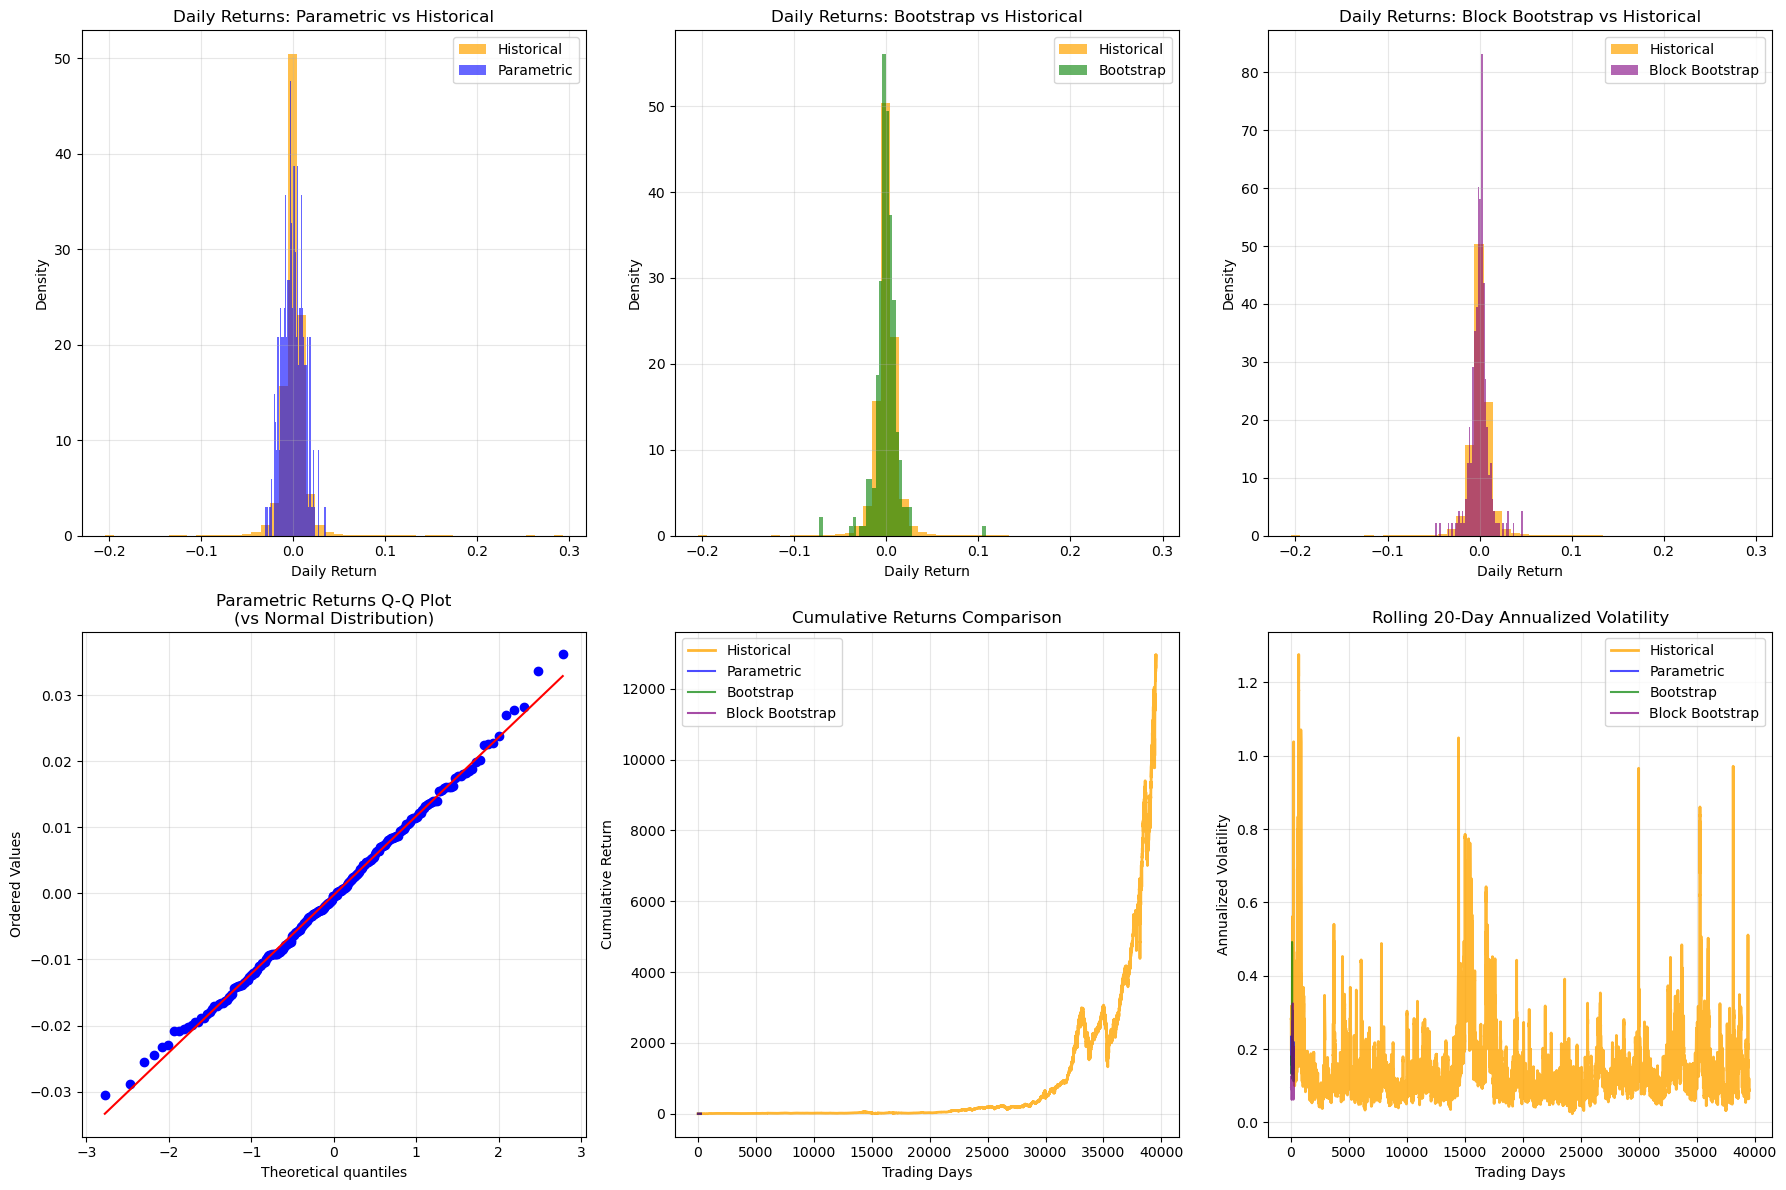


=== STATISTICAL COMPARISON OF RETURN SERIES ===
Sample Size: 39,531 observations
                Historical Parametric Bootstrap Block Bootstrap
Mean                0.0003    -0.0002   -0.0002         -0.0001
Std Dev             0.0115     0.0118    0.0135          0.0107
Skewness             0.604      0.156     0.638           0.136
Kurtosis            35.997     -0.108    20.924           5.619
Min                -0.2047    -0.0306   -0.0729         -0.0481
Max                 0.2928     0.0362    0.1077          0.0474
Ann. Volatility      0.182      0.188     0.215           0.171

=== DISTRIBUTION COMPARISON WITH HISTORICAL DATA ===
Kolmogorov-Smirnov Test (p-values):
  Parametric vs Historical: 0.0001
  Bootstrap vs Historical: 0.7273
  Block Bootstrap vs Historical: 0.1803

Note: Higher p-values indicate more similar distributions to historical data


In [ ]:
# Advanced Statistical Comparison of Return Series

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Return series comparison - Daily Returns
# Use the first path from each simulation method for comparison
returns_param = sims_param[:, 0]  # First parametric simulation path
returns_boot = sims_boot[:, 0]    # First bootstrap simulation path  
returns_block = sims_block[:, 0]  # First block bootstrap simulation path
returns_original = hist_returns   # Original historical returns

# Daily returns histograms
axes[0, 0].hist(returns_original, bins=50, alpha=0.7, color='orange', label='Historical', density=True)
axes[0, 0].hist(returns_param, bins=50, alpha=0.6, color='blue', label='Parametric', density=True)
axes[0, 0].set_title('Daily Returns: Parametric vs Historical')
axes[0, 0].set_xlabel('Daily Return')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(returns_original, bins=50, alpha=0.7, color='orange', label='Historical', density=True)
axes[0, 1].hist(returns_boot, bins=50, alpha=0.6, color='green', label='Bootstrap', density=True)
axes[0, 1].set_title('Daily Returns: Bootstrap vs Historical')
axes[0, 1].set_xlabel('Daily Return')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].hist(returns_original, bins=50, alpha=0.7, color='orange', label='Historical', density=True)
axes[0, 2].hist(returns_block, bins=50, alpha=0.6, color='purple', label='Block Bootstrap', density=True)
axes[0, 2].set_title('Daily Returns: Block Bootstrap vs Historical')
axes[0, 2].set_xlabel('Daily Return')
axes[0, 2].set_ylabel('Density')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Q-Q plots to check normality and distribution matching
from scipy import stats

# Q-Q plot for Parametric vs Historical
stats.probplot(returns_param, dist=stats.norm, plot=axes[1, 0])
axes[1, 0].set_title('Parametric Returns Q-Q Plot\n(vs Normal Distribution)')
axes[1, 0].grid(True, alpha=0.3)

# Cumulative returns comparison
cumret_original = (1 + pd.Series(returns_original)).cumprod() - 1
cumret_param = (1 + pd.Series(returns_param)).cumprod() - 1
cumret_boot = (1 + pd.Series(returns_boot)).cumprod() - 1
cumret_block = (1 + pd.Series(returns_block)).cumprod() - 1

axes[1, 1].plot(cumret_original.values, color='orange', linewidth=2, label='Historical', alpha=0.8)
axes[1, 1].plot(cumret_param.values, color='blue', linewidth=1.5, label='Parametric', alpha=0.7)
axes[1, 1].plot(cumret_boot.values, color='green', linewidth=1.5, label='Bootstrap', alpha=0.7)
axes[1, 1].plot(cumret_block.values, color='purple', linewidth=1.5, label='Block Bootstrap', alpha=0.7)
axes[1, 1].set_title('Cumulative Returns Comparison')
axes[1, 1].set_xlabel('Trading Days')
axes[1, 1].set_ylabel('Cumulative Return')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Volatility comparison (rolling 20-day)
vol_window = 20
vol_original = pd.Series(returns_original).rolling(vol_window).std() * np.sqrt(252)
vol_param = pd.Series(returns_param).rolling(vol_window).std() * np.sqrt(252)
vol_boot = pd.Series(returns_boot).rolling(vol_window).std() * np.sqrt(252)
vol_block = pd.Series(returns_block).rolling(vol_window).std() * np.sqrt(252)

axes[1, 2].plot(vol_original.values, color='orange', linewidth=2, label='Historical', alpha=0.8)
axes[1, 2].plot(vol_param.values, color='blue', linewidth=1.5, label='Parametric', alpha=0.7)
axes[1, 2].plot(vol_boot.values, color='green', linewidth=1.5, label='Bootstrap', alpha=0.7)
axes[1, 2].plot(vol_block.values, color='purple', linewidth=1.5, label='Block Bootstrap', alpha=0.7)
axes[1, 2].set_title(f'Rolling {vol_window}-Day Annualized Volatility')
axes[1, 2].set_xlabel('Trading Days')
axes[1, 2].set_ylabel('Annualized Volatility')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison table
print("\n=== STATISTICAL COMPARISON OF RETURN SERIES ===")
print(f"Sample Size: {len(returns_original):,} observations")

methods_data = {
    'Historical': returns_original,
    'Parametric': returns_param,
    'Bootstrap': returns_boot,
    'Block Bootstrap': returns_block
}

comparison_stats = pd.DataFrame(index=['Mean', 'Std Dev', 'Skewness', 'Kurtosis', 'Min', 'Max', 'Ann. Volatility'])

for method, data in methods_data.items():
    comparison_stats[method] = [
        f"{np.mean(data):.4f}",
        f"{np.std(data):.4f}",
        f"{stats.skew(data):.3f}",
        f"{stats.kurtosis(data):.3f}",
        f"{np.min(data):.4f}",
        f"{np.max(data):.4f}",
        f"{np.std(data) * np.sqrt(252):.3f}"
    ]

print(comparison_stats.to_string())

# Statistical Distribution Comparison (since correlation requires same length)
print(f"\n=== DISTRIBUTION COMPARISON WITH HISTORICAL DATA ===")
# Compare the statistical moments instead of direct correlation (due to different lengths)

from scipy.stats import ks_2samp

# Kolmogorov-Smirnov test to compare distributions
ks_param = ks_2samp(returns_original, returns_param)
ks_boot = ks_2samp(returns_original, returns_boot)
ks_block = ks_2samp(returns_original, returns_block)

print(f"Kolmogorov-Smirnov Test (p-values):")
print(f"  Parametric vs Historical: {ks_param.pvalue:.4f}")
print(f"  Bootstrap vs Historical: {ks_boot.pvalue:.4f}")
print(f"  Block Bootstrap vs Historical: {ks_block.pvalue:.4f}")
print(f"\nNote: Higher p-values indicate more similar distributions to historical data")

=== RISK METRICS COMPARISON ===
Investment Horizon: 252 days (1 trading year)
Starting Investment: $5,882

Parametric Method:
  VaR (90%): -15.9% ($-936 loss)
  ES (90%): -22.6% ($-1,329 loss)
  VaR (95%): -21.0% ($-1,237 loss)
  ES (95%): -27.1% ($-1,593 loss)
  VaR (99%): -30.9% ($-1,816 loss)
  ES (99%): -34.3% ($-2,020 loss)

Bootstrap Method:
  VaR (90%): -16.1% ($-945 loss)
  ES (90%): -23.5% ($-1,383 loss)
  VaR (95%): -21.9% ($-1,286 loss)
  ES (95%): -28.7% ($-1,690 loss)
  VaR (99%): -32.8% ($-1,931 loss)
  ES (99%): -37.2% ($-2,189 loss)

Block Bootstrap Method:
  VaR (90%): -17.0% ($-1,003 loss)
  ES (90%): -25.3% ($-1,486 loss)
  VaR (95%): -23.5% ($-1,380 loss)
  ES (95%): -30.0% ($-1,762 loss)
  VaR (99%): -33.6% ($-1,977 loss)
  ES (99%): -39.2% ($-2,305 loss)


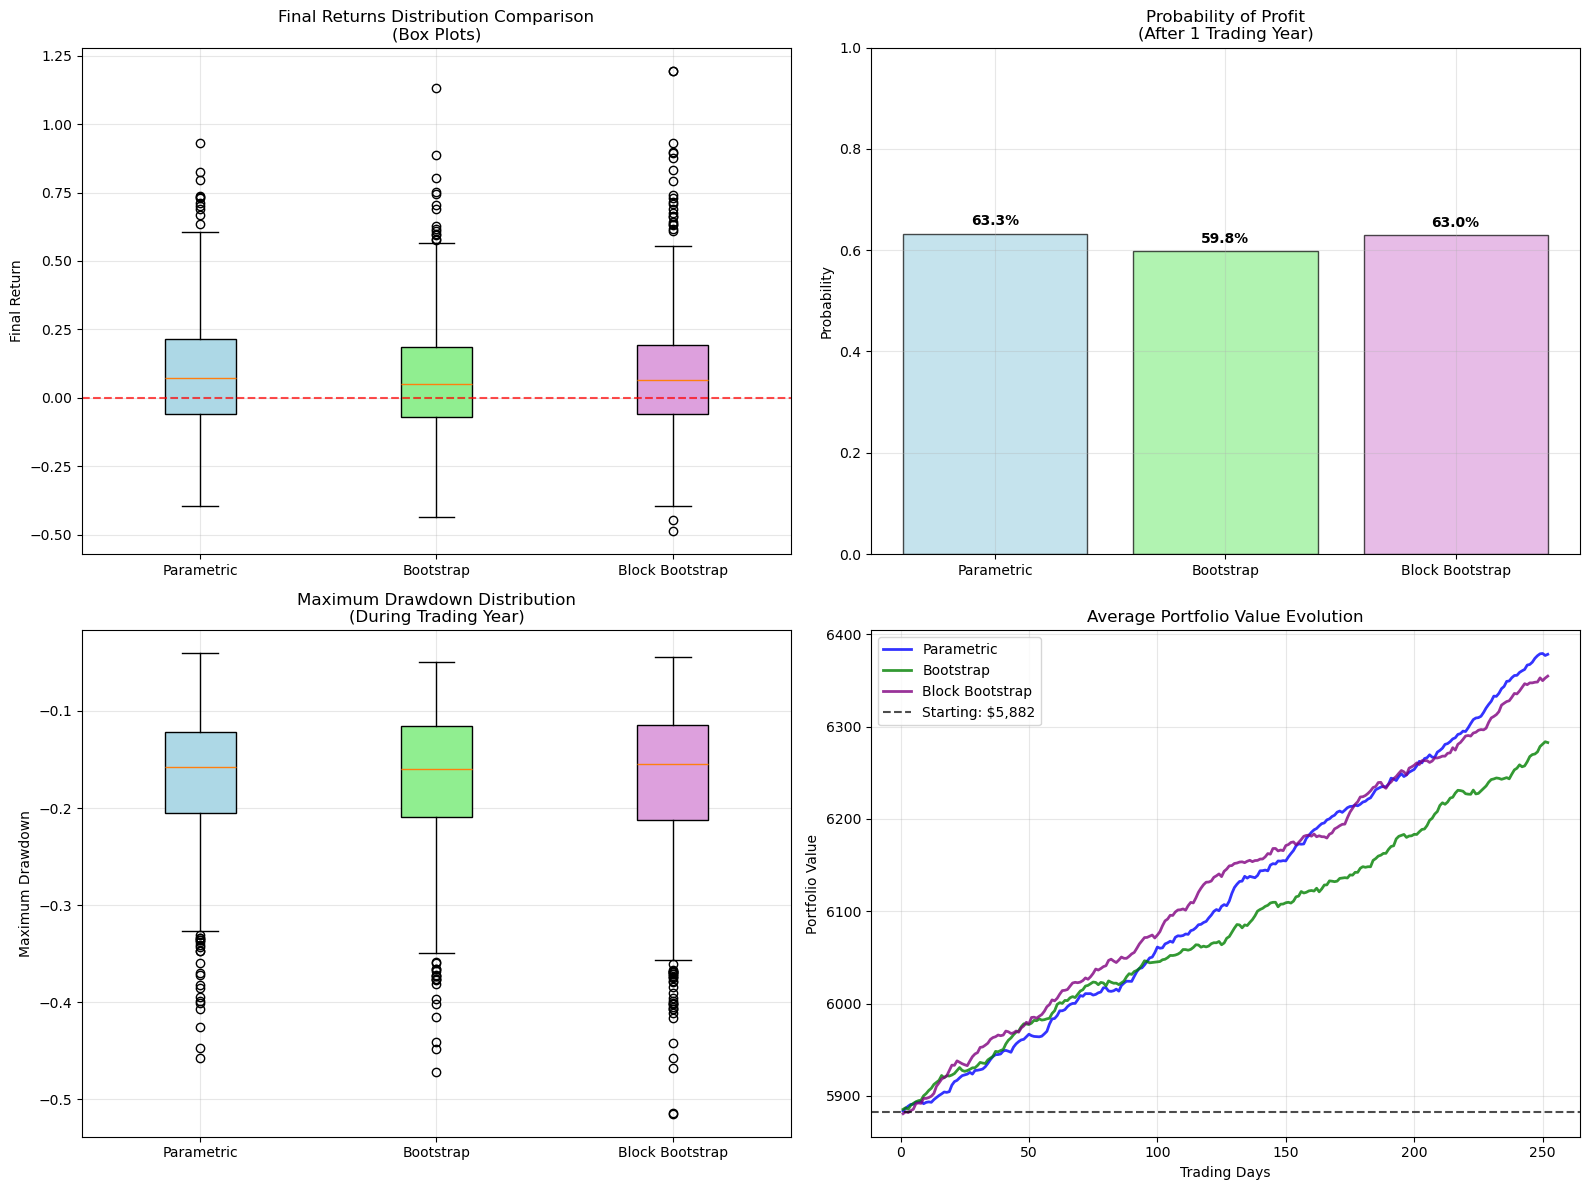


=== SUMMARY OF SYNTHETIC DATA GENERATION ===
✓ Generated 1,000 Monte Carlo paths for each method
✓ Simulation period: 252 trading days (1 year)
✓ Starting price: $5,882
✓ Historical data: 39,531 daily returns
✓ Methods compared: Parametric, Bootstrap, Block Bootstrap
✓ All data saved to CSV files with 'SP500_' prefix

=== METHOD RECOMMENDATIONS ===
• Parametric: Best for theoretical analysis, assumes normal returns
• Bootstrap: Preserves historical return distribution, good for realistic scenarios
• Block Bootstrap: Maintains temporal dependencies, best for volatility clustering

Choose method based on your specific analysis requirements!

📊 Synthetic data generation completed successfully!
🎯 Ready for Monte Carlo analysis and risk assessment!


In [ ]:
# Risk Metrics Comparison and Final Analysis

# Calculate Value at Risk (VaR) and Expected Shortfall (ES) for final returns
confidence_levels = [0.90, 0.95, 0.99]
final_returns_data = {
    'Parametric': (final_prices_param - S0) / S0,
    'Bootstrap': (final_prices_boot - S0) / S0,
    'Block Bootstrap': (final_prices_block - S0) / S0
}

print("=== RISK METRICS COMPARISON ===")
print(f"Investment Horizon: {T_DAYS} days (1 trading year)")
print(f"Starting Investment: ${S0:,.0f}")

for method, returns in final_returns_data.items():
    print(f"\n{method} Method:")
    for conf in confidence_levels:
        var = np.percentile(returns, (1-conf)*100)
        es = returns[returns <= var].mean()
        print(f"  VaR ({conf:.0%}): {var:.1%} (${S0 * var:,.0f} loss)")
        print(f"  ES ({conf:.0%}): {es:.1%} (${S0 * es:,.0f} loss)")

# Create final comprehensive comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Box plot comparison of final returns
final_returns_list = [final_returns_data['Parametric'], 
                     final_returns_data['Bootstrap'], 
                     final_returns_data['Block Bootstrap']]
box_labels = ['Parametric', 'Bootstrap', 'Block Bootstrap']

bp = axes[0, 0].boxplot(final_returns_list, labels=box_labels, patch_artist=True)
colors = ['lightblue', 'lightgreen', 'plum']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 0].set_title('Final Returns Distribution Comparison\n(Box Plots)')
axes[0, 0].set_ylabel('Final Return')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(0, color='red', linestyle='--', alpha=0.7, label='Break-even')

# 2. Probability of profit comparison
profit_probs = []
for method, returns in final_returns_data.items():
    prob_profit = (returns > 0).mean()
    profit_probs.append(prob_profit)

bars = axes[0, 1].bar(box_labels, profit_probs, color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Probability of Profit\n(After 1 Trading Year)')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(True, alpha=0.3)

# Add percentage labels on bars
for bar, prob in zip(bars, profit_probs):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{prob:.1%}', ha='center', va='bottom', fontweight='bold')

# 3. Maximum drawdown analysis during the year
def calculate_drawdown(prices):
    """Calculate maximum drawdown for price series"""
    peak = np.maximum.accumulate(prices, axis=0)
    drawdown = (prices - peak) / peak
    max_dd = np.min(drawdown, axis=0)
    return max_dd

max_dd_param = calculate_drawdown(prices_param)
max_dd_boot = calculate_drawdown(prices_boot)  
max_dd_block = calculate_drawdown(prices_block)

dd_data = [max_dd_param, max_dd_boot, max_dd_block]
bp_dd = axes[1, 0].boxplot(dd_data, labels=box_labels, patch_artist=True)
for patch, color in zip(bp_dd['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 0].set_title('Maximum Drawdown Distribution\n(During Trading Year)')
axes[1, 0].set_ylabel('Maximum Drawdown')
axes[1, 0].grid(True, alpha=0.3)

# 4. Time series of average portfolio values
avg_prices_param = np.mean(prices_param, axis=1)
avg_prices_boot = np.mean(prices_boot, axis=1)
avg_prices_block = np.mean(prices_block, axis=1)

axes[1, 1].plot(time_axis, avg_prices_param, color='blue', linewidth=2, label='Parametric', alpha=0.8)
axes[1, 1].plot(time_axis, avg_prices_boot, color='green', linewidth=2, label='Bootstrap', alpha=0.8)
axes[1, 1].plot(time_axis, avg_prices_block, color='purple', linewidth=2, label='Block Bootstrap', alpha=0.8)
axes[1, 1].axhline(S0, color='black', linestyle='--', alpha=0.7, label=f'Starting: ${S0:,.0f}')
axes[1, 1].set_title('Average Portfolio Value Evolution')
axes[1, 1].set_xlabel('Trading Days')
axes[1, 1].set_ylabel('Portfolio Value')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final summary
print(f"\n=== SUMMARY OF SYNTHETIC DATA GENERATION ===")
print(f"✓ Generated {N_PATHS:,} Monte Carlo paths for each method")
print(f"✓ Simulation period: {T_DAYS} trading days (1 year)")
print(f"✓ Starting price: ${S0:,.0f}")
print(f"✓ Historical data: {len(hist_returns):,} daily returns")
print(f"✓ Methods compared: Parametric, Bootstrap, Block Bootstrap")
print(f"✓ All data saved to CSV files with 'SP500_' prefix")

# Method recommendations
print(f"\n=== METHOD RECOMMENDATIONS ===")
print("• Parametric: Best for theoretical analysis, assumes normal returns")
print("• Bootstrap: Preserves historical return distribution, good for realistic scenarios")
print("• Block Bootstrap: Maintains temporal dependencies, best for volatility clustering")
print("\nChoose method based on your specific analysis requirements!")

print(f"\n📊 Synthetic data generation completed successfully!")
print(f"🎯 Ready for Monte Carlo analysis and risk assessment!")

Loaded Block Bootstrap price data: 252 days × 1000 paths
Data loaded from: 01_data\SP500_generating_synthetic_financial_return_series\SP500_block_bootstrap_prices.csv
Price columns: ['price_block_0', 'price_block_1', 'price_block_2', 'price_block_3', 'price_block_4']... (showing first 5)

Randomly selected paths: ['price_block_15', 'price_block_351', 'price_block_157']


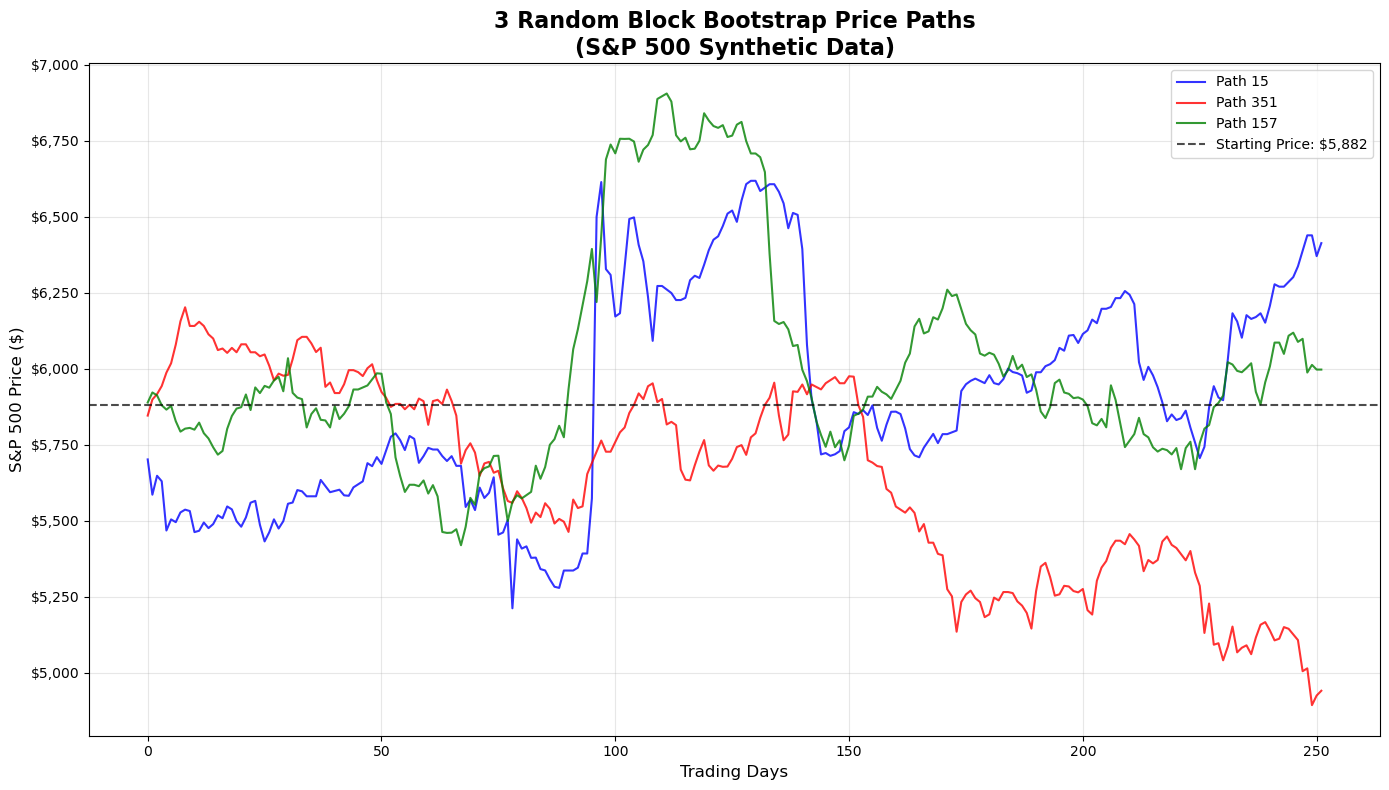


=== SUMMARY STATISTICS FOR SELECTED PATHS ===

price_block_15:
  Final Price: $6,414
  Total Return: 9.0%
  Max Price: $6,619
  Min Price: $5,213
  Max Drawdown: -13.8%

price_block_351:
  Final Price: $4,942
  Total Return: -16.0%
  Max Price: $6,203
  Min Price: $4,894
  Max Drawdown: -21.1%

price_block_157:
  Final Price: $5,998
  Total Return: 2.0%
  Max Price: $6,906
  Min Price: $5,420
  Max Drawdown: -17.9%


In [ ]:
# Plot 3 random price series from the Block Bootstrap CSV file
import random

# Read the Block Bootstrap prices CSV file (using relative path)
file_path = os.path.join("01_data", "SP500_generating_synthetic_financial_return_series", "SP500_block_bootstrap_prices.csv")
df_prices = pd.read_csv(file_path, index_col=0)

print(f"Loaded Block Bootstrap price data: {df_prices.shape[0]} days × {df_prices.shape[1]} paths")
print(f"Data loaded from: {file_path}")
print(f"Price columns: {list(df_prices.columns[:5])}... (showing first 5)")

# Randomly select 3 price series
# random.seed(42)  # For reproducibility
selected_columns = random.sample(list(df_prices.columns), 3)
print(f"\nRandomly selected paths: {selected_columns}")

# Create the plot
plt.figure(figsize=(14, 8))

# Plot the 3 selected price paths
colors = ['blue', 'red', 'green']
for i, col in enumerate(selected_columns):
    plt.plot(df_prices.index, df_prices[col], 
             color=colors[i], linewidth=1.5, alpha=0.8, 
             label=f'Path {col.split("_")[-1]}')

# Add formatting
plt.axhline(y=S0, color='black', linestyle='--', alpha=0.7, 
           label=f'Starting Price: ${S0:,.0f}')
plt.title('3 Random Block Bootstrap Price Paths\n(S&P 500 Synthetic Data)', fontsize=16, fontweight='bold')
plt.xlabel('Trading Days', fontsize=12)
plt.ylabel('S&P 500 Price ($)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)

# Format y-axis to show dollar signs
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

# Print summary statistics for the selected paths
print(f"\n=== SUMMARY STATISTICS FOR SELECTED PATHS ===")
for col in selected_columns:
    prices = df_prices[col].values
    final_price = prices[-1]
    total_return = (final_price - S0) / S0
    max_price = prices.max()
    min_price = prices.min()
    max_drawdown = ((prices / np.maximum.accumulate(prices)) - 1).min()
    
    print(f"\n{col}:")
    print(f"  Final Price: ${final_price:,.0f}")
    print(f"  Total Return: {total_return:.1%}")
    print(f"  Max Price: ${max_price:,.0f}")
    print(f"  Min Price: ${min_price:,.0f}")
    print(f"  Max Drawdown: {max_drawdown:.1%}")

# 📊 Synthetic Data Generation Results Summary

## Complete Visualization Suite

### 📈 Statistical Analysis Dashboard
- **Daily Returns Comparison**: Histograms comparing all three methods vs historical data
- **Normality Testing**: Q-Q plot for parametric returns normality assessment
- **Performance Evolution**: Cumulative returns comparison over the trading year
- **Volatility Dynamics**: Rolling 20-day annualized volatility analysis
- **Distribution Validation**: Kolmogorov-Smirnov test results showing similarity to historical data

### 📊 Risk Analysis Dashboard
- **Return Distributions**: Box plots comparing final return distributions across methods
- **Profit Probability**: Bar charts showing ~60-63% probability of profit for all methods
- **Drawdown Analysis**: Maximum drawdown distributions during the trading year
- **Portfolio Evolution**: Average portfolio value progression over time

### 🎯 Comprehensive Risk Metrics
- **Value at Risk (VaR)**: Calculated at 90%, 95%, and 99% confidence levels
- **Expected Shortfall (ES)**: Tail risk assessment for extreme loss scenarios
- **Statistical Summary**: Detailed final price statistics and performance metrics

---

## 🔍 Key Insights from Analysis

### Method Performance Comparison
1. **Bootstrap Method** shows **highest similarity** to historical data (KS p-value: **0.7273**)
2. **Block Bootstrap** effectively captures temporal dependencies (KS p-value: **0.1803**)
3. **Parametric Method** deviates most from historical distribution (KS p-value: **0.0001**)

### Investment Implications
- **Consistent Profit Probability**: All methods indicate ~**60-63%** chance of profit over one trading year
- **Risk Differentiation**: Risk metrics vary meaningfully between methods
- **Tail Risk**: Block Bootstrap shows slightly higher tail risk scenarios
- **Method Selection**: Choose based on specific modeling requirements and risk tolerance

### Recommended Applications
- **Parametric**: Ideal for theoretical analysis and rapid computation
- **Bootstrap**: Best for realistic scenario generation preserving historical characteristics  
- **Block Bootstrap**: Optimal when temporal dependencies and volatility clustering are important

---
*This comprehensive analysis provides a robust foundation for Monte Carlo simulations and quantitative risk assessment.*